<font size="6"> Generating Sensitive Samples With TensorFlow  <font/>

<font size="3"> Numerous cloud-based services are provided to help customers develop and deploy deep learning applications. When a customer deploys a deep learning model in the cloud and serves it to end-users, it is important to be able to verify that the deployed model has not been tampered with. In paper (https://openaccess.thecvf.com/content_CVPR_2019/html/He_Sensitive-Sample_Fingerprinting_of_Deep_Neural_Networks_CVPR_2019_paper.html), the authors propose a novel and practical methodology to verify the integrity of remote deep learning models, with only black-box access to the target models. Specifically, they introduce Sensitive-Sample fingerprints, which are a small set of human unnoticeable transformed inputs that make the model outputs sensitive to the model's parameters. Even small model changes can be clearly reflected in the model outputs. In this notebook, we generate sensitive samples for a ResNet-20 model trained on CIFAR-10 dataset.<font/>

<font size="5"> Importing libraries  <font/>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from keras import backend as K
from keras.models import load_model
from keras.datasets import cifar10
import numpy as np
import random
import matplotlib.pyplot as plt

<font size="5"> Loading the CIFAR-10 dataset and scaling image pixels to [0,1]  <font/>

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10
# Normalize data.
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

<font size="5"> Loading the pre-trained ResNet-20 Model  <font/>

In [3]:
model_name = 'cifar10'
original_model = load_model(model_name+'.hdf5')
print(original_model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activ

<font size="5"> Defining the Sesitivity Score  <font/>

In [5]:
parameters_of_interest = 'dense_1'

sensitivity_score = 0
for layer  in original_model.layers:
	if layer.name in parameters_of_interest:  
		print("Parameters of ",layer.name, " considered for gradient maximization!")
		weights,biases = layer.trainable_weights
		for j in range(num_classes):
			weights_grads = K.gradients(original_model.output[:,j],[weights])[0] ## Calculating gradients of "weights" w.r.t output j
			biases_grads = K.gradients(original_model.output[:,j],[biases])[0] ## Calculating gradients of "biases" w.r.t output j
			W_grads = K.concatenate([K.flatten(weights_grads), K.flatten(biases_grads)]) ## Gradients of all parameters (including weights and biases) of the layer w.r.t output j --> W = same notation as in the paper.
			sensitivity_score += K.sum(K.square(W_grads)) ## Squared l2 Norm of gradients of "W" w.r.t output j

get_input_grads = K.function([original_model.input],K.gradients(sensitivity_score, original_model.input)) ### This function results gradients of input of the model with respect to sensitivity loss
get_sensitivity_score = K.function([original_model.input],[sensitivity_score])

Parameters of  dense_1  considered for gradient maximization!


<font size="5"> Generating A Sensitive Sample  <font/>

In [6]:
allowed_l2_noise = 0.25
input_img = x_train[46472,::] ## choosing a sample from training set as V
org_input_img = np.copy(input_img)

epochs = 2000
start_lr = 1e-5
best_score = -1e+100
best_input_img = None
most_sensitive_sample_so_far = None

def lr_schedule(epoch):
	if epoch < 200:
		return start_lr
	elif epoch < 500:
		return start_lr / 2.0
	elif epoch < 1000:
		return start_lr / 4.0
	elif epoch < 1500:
		return start_lr / 8.0
	else:
		return start_lr / 16.0

for e in range(epochs):
	lr = lr_schedule(e)
	input_grads = (get_input_grads([input_img.reshape((1,)+input_img.shape)])[0]).reshape(input_img.shape)
	input_img = input_img + lr * input_grads
	input_img = np.clip(input_img, 0.0, 1.0) ## Asserting the range for acceptable images


	##### project back to allowed l2 ball ####
	delta = input_img - org_input_img
	if np.linalg.norm(delta) != 0.0:
		delta *= min(np.linalg.norm(delta),allowed_l2_noise)/np.linalg.norm(delta)

	input_img  = org_input_img + delta 

	sensitivity_score_value = get_sensitivity_score([input_img.reshape((1,)+input_img.shape)])[0]

	if best_score < sensitivity_score_value:
		best_score = sensitivity_score_value
		most_sensitive_sample_so_far = np.copy(input_img)

	print('[',e,'] ', " sensitivity score: ", sensitivity_score_value, end='\r')

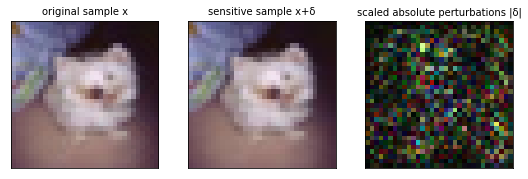

In [12]:
plt.figure(figsize=(9,3))
ax = plt.subplot(1,3,1)
ax.imshow(most_sensitive_sample_so_far)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('original sample x',fontsize=10)

ax = plt.subplot(1,3,2)
ax.imshow(org_input_img)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('sensitive sample x+δ',fontsize=10)

ax = plt.subplot(1,3,3)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('scaled absolute perturbations |δ|',fontsize=10)

delta = np.abs(most_sensitive_sample_so_far-org_input_img)
delta = delta / np.max(delta)
ax.imshow(delta)
plt.savefig('sensitive-samples.png')